# 1: Abstract
This analysis is based on the challenge of [SIEMENS](https://www.mobility.siemens.com/ch/en.html) at [HackZurich 2021](https://hackzurich.com). With the callenge, data from one of their train-communication-systems was provided. The task was to detect, predict and categorize failures. See the [challenge documentation](https://github.com/croidzen/hz21-sc/blob/main/challenge_documentation/Workshop_Siemens_Mobility_20210924.pdf) for further information about the challenge.

Our team's approach was to transform the provided data from train-based to track-based and then build a predictive maintenance model for the degradation-based emergency-stops.

<br>
<img src="sketches/data_transformation.png" alt="data transformation" width="500"/>
<br>
<img src="sketches/forecasting_method.png" alt="forecast" width="400"/>

The original hackathon code can be found [here](https://github.com/Noorts/hz21-sc) and [here](https://github.com/SanjoyPator1/HackZurichBackend), this repo contains an [analysis done afterwards](https://github.com/croidzen/hz21-sc/blob/main/analytics.ipynb).

# 2: Data preparation

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

## Transform 'rssi.csv' to track segment passes

In [92]:
# Load data
df_rssi = pd.read_csv('data/rssi.csv')

In [93]:
# Parse datetime and resort by timestamp

df_rssi['DateTime'] = pd.to_datetime(df_rssi['DateTime'], format='%Y-%m-%d %H:%M:%S')
df_rssi = df_rssi.sort_values(by='DateTime')
df_rssi = df_rssi.reset_index()
df_rssi['ID'] = df_rssi.index

In [94]:
# Drop invalid RSSI values

df_rssi.loc[(df_rssi['A2_RSSI']<0.9), 'A2_RSSI'] = np.nan
df_rssi.loc[(df_rssi['A2_RSSI']>2.9), 'A2_RSSI'] = np.nan

In [95]:
# create feature 'TourID'

df_rssi['AreaNumerDif'] = df_rssi['AreaNumber'] - df_rssi['AreaNumber'].shift(-1) # find new stations
df_rssi.loc[df_rssi['AreaNumerDif']>0, 'AreaNumerDif'] = 1 # steps between stations always 1 or -1, depending on train direction
df_rssi.loc[df_rssi['AreaNumerDif']<0, 'AreaNumerDif'] = -1
df_rssi['AreaNumerDif'] = df_rssi['AreaNumerDif'].replace(0, np.nan) # nan where no change of station
df_rssi['AreaNumerDif'] = df_rssi['AreaNumerDif'].fillna(method='backfill') # fill with direction of next station change
df_rssi['AreaNumerDif'] = df_rssi['AreaNumerDif'].fillna(method='ffill') # fill last rows of dataset

df_rssi['AreaNumerDifDif'] = df_rssi['AreaNumerDif'] - df_rssi['AreaNumerDif'].shift(-1) # find shifts of direction
df_rssi.loc[df_rssi['AreaNumerDifDif']!=0, 'AreaNumerDifDif'] = df_rssi.loc[df_rssi['AreaNumerDifDif']!=0, 'ID'] # set row id where direction changes
df_rssi['AreaNumerDifDif'] = df_rssi['AreaNumerDifDif'].replace(0, np.nan) # nan, where no change of direction
df_rssi['AreaNumerDifDif'] = df_rssi['AreaNumerDifDif'].fillna(method='backfill') # fill with TourID of next TourID
df_rssi.rename(columns = {'AreaNumerDifDif':'TourID'}, inplace = True)

# rename tours as 1..n
tours = pd.DataFrame()
tours['TourID']= pd.Series(df_rssi['TourID'].unique())
tours['NewTourID'] = tours.index.values
tours = tours.set_index('TourID')['NewTourID']
df_rssi['TourID'] = df_rssi['TourID'].map(tours)

In [96]:
# create feature 'TrackSegment'
# (100m track segment length is guessed to be a good compromise between resolution of given data and result precision)
# (Segments are numbered as 97-420 to represent the track position 9,7 to 42,x km)

df_rssi['TrackSegment'] = df_rssi['PositionNoLeap'] / 1000
df_rssi['TrackSegment'] = df_rssi['TrackSegment'].astype(int) # cut last digits

In [97]:
# Create feature 'SNR'

df_rssi['A1_TotalTelDif'] = df_rssi['A1_TotalTel'] - df_rssi['A1_TotalTel'].shift(1)
df_rssi['A1_ValidTelDif'] = df_rssi['A1_ValidTel'] - df_rssi['A1_ValidTel'].shift(1)
df_rssi['SNR1'] = df_rssi['A1_ValidTelDif'] / df_rssi['A1_TotalTelDif']

df_rssi['A2_TotalTelDif'] = df_rssi['A2_TotalTel'] - df_rssi['A2_TotalTel'].shift(1)
df_rssi['A2_ValidTelDif'] = df_rssi['A2_ValidTel'] - df_rssi['A2_ValidTel'].shift(1)
df_rssi['SNR2'] = df_rssi['A2_ValidTelDif'] / df_rssi['A2_TotalTelDif']

In [98]:
# Transform dataframe

aggregations = {
    'DateTime': ['first', 'last', 'count'],  # Todo: Close time-gaps between track segments
    'Latitude': 'mean',
    'Longitude': 'mean',
    'A2_RSSI': ['min', 'mean', 'std'],
    'SNR1': ['min', 'mean', 'std'],
    'SNR2': ['min', 'mean', 'std'],
    'Track': 'first'}  # Todo: Track might change within a segment
df_segments = df_rssi.groupby(['TrackSegment', 'TourID']).agg(aggregations)

df_segments.columns = ['_'.join(column) for column in df_segments.columns.to_flat_index()] # flatten multi level columns
df_segments = df_segments.reset_index()  # flatten index

## Adding e-stops from 'disruptions.csv' as labels

In [99]:
# Read data
df_disruptions = pd.read_csv('data/disruptions.csv')

In [100]:
# Remove all disruptions except estops
df_disruptions = df_disruptions[df_disruptions['DisruptionCode'] == 960862267]

In [101]:
# Parse datetimes

df_disruptions['DateTime'] = pd.to_datetime(df_disruptions['DateTime'], format='%Y-%m-%d %H:%M:%S')
df_disruptions = df_disruptions.sort_values(by='DateTime')
df_disruptions = df_disruptions.reset_index()

In [102]:
# Estops while velocity = 0 need to be excluded --> read 'velocities.csv' and parse datetimes

df_velocities = pd.read_csv('data/velocities.csv')
df_velocities['DateTime'] = pd.to_datetime(df_velocities['DateTime'], format='%Y-%m-%d %H:%M:%S')
df_velocities = df_velocities.set_index('DateTime')

In [103]:
# Map velocities to disruptions

velocities = []
for _, row in df_disruptions.iterrows():
    if row['DateTime'] in df_velocities.index:
        velocities.append(df_velocities.loc[row['DateTime'], 'CurrentVelocity'])
    else:
        velocities.append(0)
df_disruptions['velocity'] = velocities

In [104]:
# Remove disruptions with velocity equal to zero
df_disruptions = df_disruptions[df_disruptions['velocity'] > 0]

In [105]:
# Count estops per track segment pass

def count_estops(dates_series:pd.Series) -> None:
    estops = df_disruptions['DateTime'].between(dates_series[0], dates_series[1])
    return estops.sum()

tqdm.pandas()
estops = df_segments[['DateTime_first', 'DateTime_last']].progress_apply(count_estops, axis=1)
df_segments['n_estops'] = estops

100%|██████████| 1091846/1091846 [06:11<00:00, 2938.50it/s]


In [106]:
df_segments.head()

,TrackSegment,TourID,DateTime_first,DateTime_last,DateTime_count,Latitude_mean,Longitude_mean,A2_RSSI_min,A2_RSSI_mean,A2_RSSI_std,SNR1_min,SNR1_mean,SNR1_std,SNR2_min,SNR2_mean,SNR2_std,Track_first,n_estops
0,97,0,2020-01-22 00:00:01,2020-01-28 08:13:57,59175,47.304858,8.049463,0.93,1.338668,0.225625,0.999611,1.00000,0.000002,0.0,0.960728,0.157886,5,0
1,97,4,2020-01-29 05:40:37,2020-01-29 05:41:15,39,47.305277,8.049646,1.88,2.471282,0.099318,1.000000,1.00000,0.000000,1.0,1.000000,0.000000,5,0
2,97,16,2020-01-30 06:49:43,2020-01-30 16:43:01,18316,47.305015,8.049532,0.93,1.685492,0.114742,0.000000,0.99939,0.015534,0.0,0.999072,0.018709,3,0
3,97,48,2020-02-04 04:41:01,2020-02-04 04:41:19,19,47.305286,8.049649,2.26,2.354211,0.125225,1.000000,1.00000,0.000000,1.0,1.000000,0.000000,2,0
4,97,50,2020-02-04 07:36:48,2020-02-04 16:29:24,31709,47.304984,8.049518,0.93,0.956754,0.074091,0.000000,0.96506,0.158184,1.0,1.000000,0.000000,2,0


In [107]:
# Write to file
# df_segments.to_csv('data/rssi_segmented.csv')

# 3: Exploratory data analysis
- Getting valuable insights by visualizing the data

## E-stops
- How is the occurrence of e-stops distributed over the track-segments?

In [108]:
# Calculate 'average estops per pass' for each track segment

estops = df_segments[['n_estops', 'TrackSegment']].groupby('TrackSegment').agg(['sum', 'count'])
estops.columns = ['_'.join(column) for column in estops.columns.to_flat_index()] # flatten multi level columns
estops['avg_estops_per_pass'] = estops['n_estops_sum'] / estops['n_estops_count']

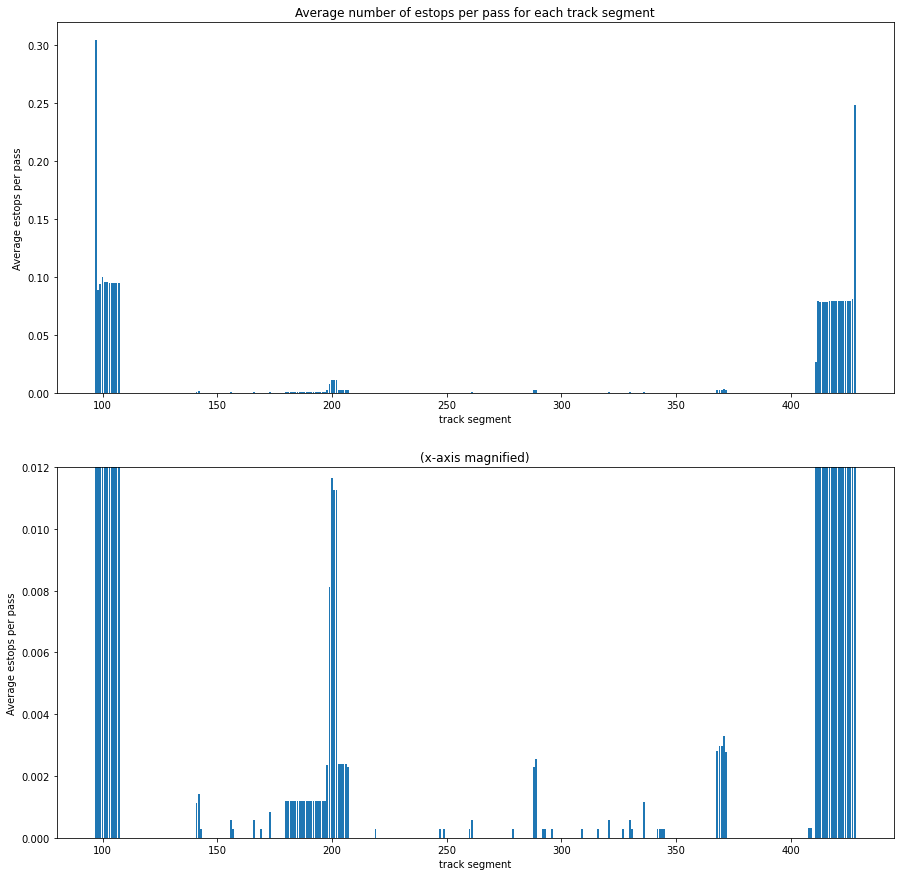

In [131]:
# Plot 'average estops per pass' for each track segment

plt.rcParams['figure.figsize'] = [15, 15]
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.bar(estops.index, estops['avg_estops_per_pass'])
ax1.set_xlabel('track segment')
ax1.set_ylabel('Average estops per pass')
ax1.set_title(f"Average number of estops per pass for each track segment")

ax2.bar(estops.index, estops['avg_estops_per_pass'])
ax2.set_xlabel('track segment')
ax2.set_ylim(0, 0.012)
ax2.set_ylabel('Average estops per pass')
ax2.set_title("(x-axis magnified)")

plt.show()

### Results

- High counts of estops on the first and last track segments with even higher spikes on the very first and last segments. A misinterpretation of the data is suspected.
- When the above mentioned areas are excluded, a clustering of estops on some areas of the track can be seen. This could help with priorization for the maintenance team, especially if the data if further filtered to only represent a recent timeframe.

## Track number
- Does the train always use the same track number?
- How many parallel tracks do exist?
- How does the usage of parallel tracks correlate to the occurrence of e-stops?

In [111]:
# For each track segment, 'df_track' contains the number of passes for each track number used

df_tracks = df_segments \
    .loc[:, ['TrackSegment', 'Track_first', 'Latitude_mean']] \
    .groupby(['TrackSegment', 'Track_first']) \
    .count() \
    .unstack(level='Track_first') \
    .droplevel(0, axis='columns')

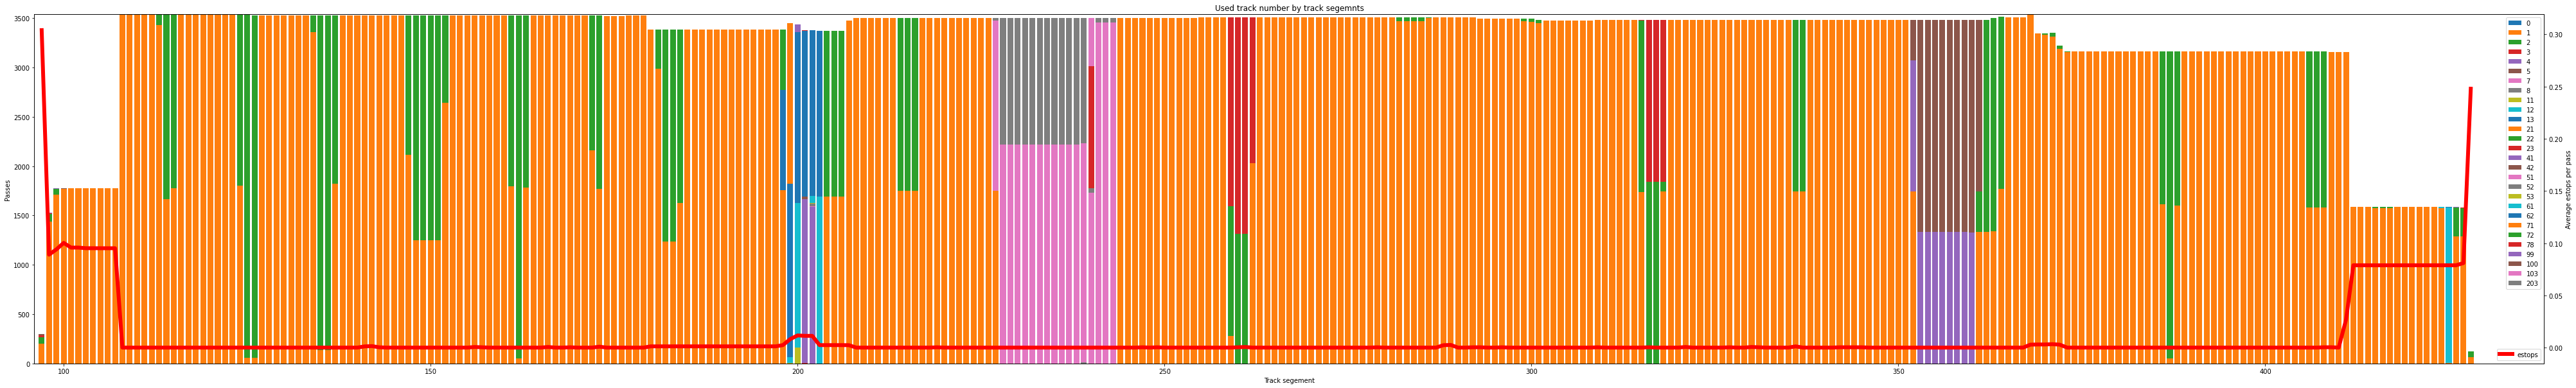

In [112]:
# For each track segment, plot the number of passes for each track number used
# Also plot the 'average estops per pass' for each track segement

df_tracks = df_tracks.replace(np.nan, 0)
fig, ax1 = plt.subplots(figsize = (70, 10))
ax2 = ax1.twinx()

# Number of passes per track number
x = df_tracks.index
bottom = len(df_tracks) * [0]
for track in df_tracks.columns:
    heights = list(df_tracks.loc[:, track])
    ax1.bar(x, heights, label=track, bottom=bottom)
    bottom = [a + b for a, b in zip(bottom, heights)]

# Average number of estops
ax2.plot(x, estops['avg_estops_per_pass'], 'r-', linewidth=6, label='estops')

ax1.set_title('Used track number by track segemnts')
ax1.set_xlim(df_tracks.index.min()-1, df_tracks.index.max()+10)
ax1.set_xlabel('Track segement')
ax1.set_ylabel('Passes')
ax2.set_ylabel('Average estops per pass')
ax1.legend(loc='upper right')
ax2.legend(loc='lower right')
plt.show()

### Results

- On a significant portion of the track segments, multiple tracks are used in parallel. As we are looking mostly at physical degradation, the forecasting should be done for each track separately. But for now, this will be tolerated and all parallel tracks within a track segment will be treated as one.
- Also, at the begin and end of the track, a much higher average number of estops correlates with a lower number of overall segment passes. As already mentioned, this should be further evalueded with the domain experts.

## Features and label for a single track segment
- How do RSSI and SNR behave on certain track segemnts over time?
- Is there any pattern observable between RSSI/SNR bahavior and e-stop occurrance?
- Is there any example of continoous signal degradation as a sign of degradation observable?

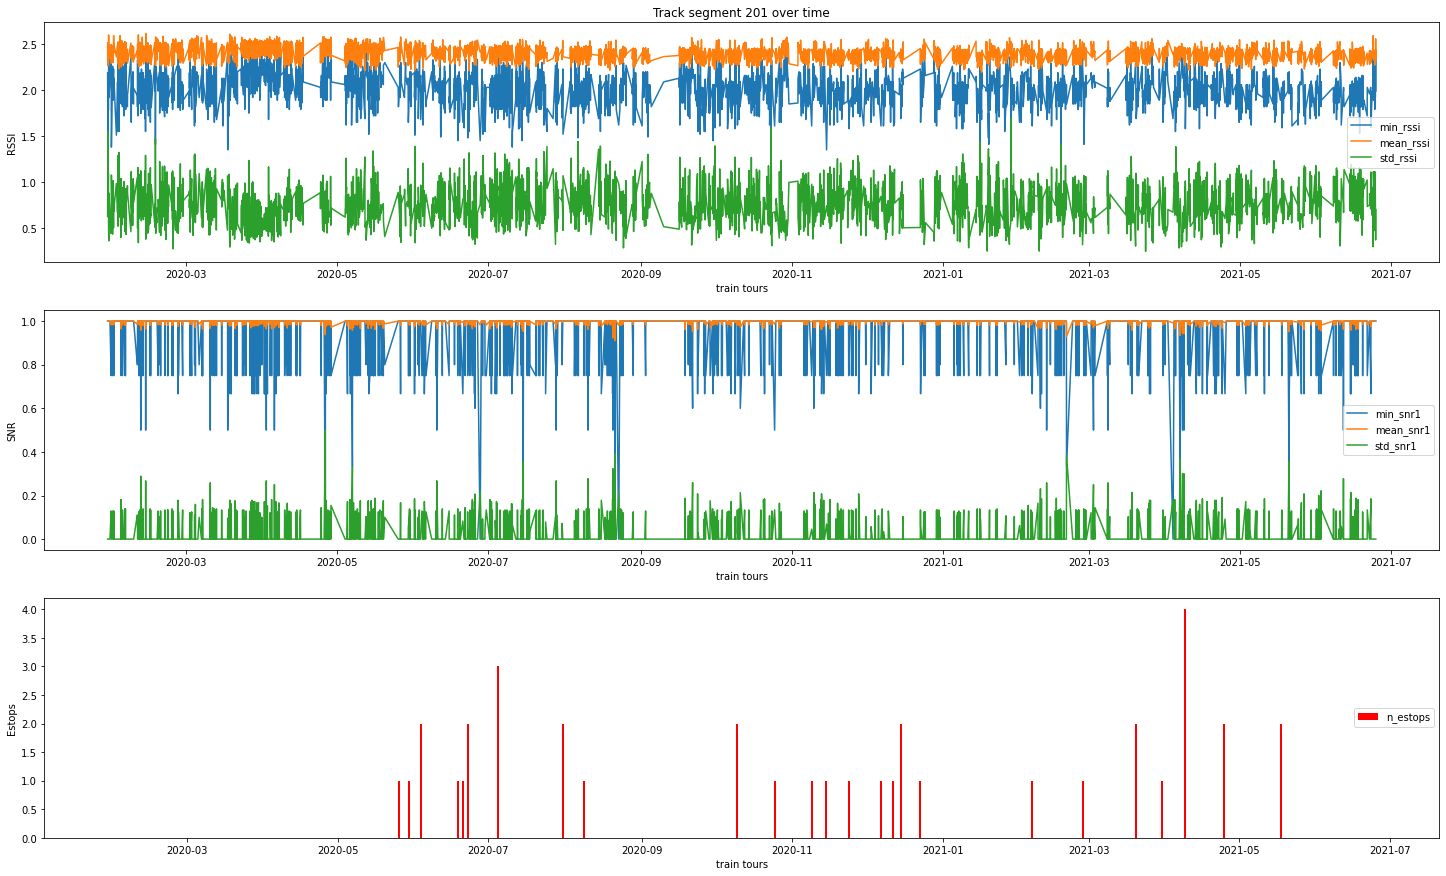

In [133]:
plt.rcParams['figure.figsize'] = [25, 15]
SEGMENT_NO = 201
segment_mask = df_segments['TrackSegment']==SEGMENT_NO

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
x = df_segments.loc[segment_mask, 'DateTime_first']

min_rssi = df_segments.loc[segment_mask, 'A2_RSSI_min']
ax1.plot(x, min_rssi, label='min_rssi')
mean_rssi = df_segments.loc[segment_mask, 'A2_RSSI_mean']
ax1.plot(x, mean_rssi, label='mean_rssi')
std_rssi = df_segments.loc[segment_mask, 'A2_RSSI_std']
ax1.plot(x, std_rssi * 5, label='std_rssi')
ax1.set_title(f"Track segment {SEGMENT_NO} over time")
ax1.set_xlabel('train tours')
ax1.set_ylabel('RSSI')
ax1.legend(loc='center right')

min_snr1 = df_segments.loc[segment_mask, 'SNR1_min']
ax2.plot(x, min_snr1, label='min_snr1')
mean_snr1 = df_segments.loc[segment_mask, 'SNR1_mean']
ax2.plot(x, mean_snr1, label='mean_snr1')
std_snr1 = df_segments.loc[segment_mask, 'SNR1_std']
ax2.plot(x, std_snr1 * 2, label='std_snr1')
ax2.set_xlabel('train tours')
ax2.set_ylabel('SNR')
ax2.legend(loc='center right')

n_estops = df_segments.loc[segment_mask, 'n_estops']
ax3.bar(x, n_estops, color='r', label='n_estops')
ax3.set_xlabel('train tours')
ax3.set_ylabel('Estops')
ax3.legend(loc='center right')

plt.show()

### Result
- No patterns or correlations between RSSI/SNR and e-stops are observable.

# 4: Estop clustering
- Can we find different reasons of estops by clustering?
- Can the degradation-based e-stops be found by clustering on the base of RSSI/SNR values of earlier passes of the same track-segments?

## Feature engineering

In [ ]:
# Add relative values of measurements that were taken on prior passes of the same segments

columns = ['TrackSegment', 'TourID', 'n_estops', 'A2_RSSI_mean', 'SNR1_mean']
lag_cols = ['A2_RSSI_mean', 'SNR1_mean']
df_estops = df_segments.loc[df_segments['n_estops']>0, columns]

for lag in range(1, 6):
    lagged_values = df_segments.loc[df_segments['n_estops'].shift(-1)>0, lag_cols]
    for col in lag_cols:
        df_estops[f'{col}-{lag}'] = lagged_values[col].values
        df_estops[f'{col}-{lag}'] = df_estops[f'{col}-{lag}'] / df_estops[col]  # change to relative
        df_estops[f'{col}-{lag}'] = df_estops[f'{col}-{lag}'].replace(np.nan, 1)  # replace nan if base value was 0
        df_estops[f'{col}-{lag}'] = df_estops[f'{col}-{lag}'].replace(np.inf, 1)  # replace inf if base value was 0
df_estops = df_estops.dropna()

## Modeling a KMeans estimator

In [116]:
# Training a 'KMeans' clustering estimator

X = df_estops.iloc[:, 5:].to_numpy()

estimator = KMeans(n_clusters=2)
estimator.fit(X)
labels = estimator.labels_

values, counts = np.unique(labels, return_counts=True)
print(values)
print(counts)


[0 1]
[3019   35]


In [117]:
# Overview of e-stops in cluster '0'
df_estops.iloc[labels==0, 5:].describe()

,A2_RSSI_mean-1,SNR1_mean-1,A2_RSSI_mean-2,SNR1_mean-2,A2_RSSI_mean-3,SNR1_mean-3,A2_RSSI_mean-4,SNR1_mean-4,A2_RSSI_mean-5,SNR1_mean-5
count,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000
mean,0.999569,1.000519,0.999569,1.000519,0.999569,1.000519,0.999569,1.000519,0.999569,1.000519
std,0.063783,0.052355,0.063783,0.052355,0.063783,0.052355,0.063783,0.052355,0.063783,0.052355
min,0.367165,0.000000,0.367165,0.000000,0.367165,0.000000,0.367165,0.000000,0.367165,0.000000
25%,0.987106,1.000000,0.987106,1.000000,0.987106,1.000000,0.987106,1.000000,0.987106,1.000000
50%,0.999275,1.000000,0.999275,1.000000,0.999275,1.000000,0.999275,1.000000,0.999275,1.000000
75%,1.011134,1.000000,1.011134,1.000000,1.011134,1.000000,1.011134,1.000000,1.011134,1.000000
max,1.590241,2.500000,1.590241,2.500000,1.590241,2.500000,1.590241,2.500000,1.590241,2.500000


In [118]:
# Overview of e-stops in cluster '1'
df_estops.iloc[labels==1, 5:].describe()

,A2_RSSI_mean-1,SNR1_mean-1,A2_RSSI_mean-2,SNR1_mean-2,A2_RSSI_mean-3,SNR1_mean-3,A2_RSSI_mean-4,SNR1_mean-4,A2_RSSI_mean-5,SNR1_mean-5
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,2.194518,1.127710,2.194518,1.127710,2.194518,1.127710,2.194518,1.127710,2.194518,1.127710
std,0.246886,0.266785,0.246886,0.266785,0.246886,0.266785,0.246886,0.266785,0.246886,0.266785
min,1.611113,0.911516,1.611113,0.911516,1.611113,0.911516,1.611113,0.911516,1.611113,0.911516
25%,2.027588,1.007603,2.027588,1.007603,2.027588,1.007603,2.027588,1.007603,2.027588,1.007603
50%,2.237621,1.041295,2.237621,1.041295,2.237621,1.041295,2.237621,1.041295,2.237621,1.041295
75%,2.384362,1.131296,2.384362,1.131296,2.384362,1.131296,2.384362,1.131296,2.384362,1.131296
max,2.620563,2.464675,2.620563,2.464675,2.620563,2.464675,2.620563,2.464675,2.620563,2.464675


In [119]:
# On which track-segments do these e-stops occur?

degradation_based_estop_indices = df_estops.index[labels==1]
df_segments.loc[degradation_based_estop_indices, ['TrackSegment', 'TourID', 'DateTime_first']]

,TrackSegment,TourID,DateTime_first
35,97,386,2020-03-16 07:36:42
39,97,616,2020-04-09 21:04:59
41,97,656,2020-04-14 21:04:37
44,97,684,2020-04-17 08:37:04
50,97,898,2020-05-20 07:42:45
59,97,986,2020-06-09 16:50:56
78,97,1396,2020-07-21 08:50:29
88,97,1602,2020-08-11 00:05:19
132,97,2100,2020-10-14 20:07:10
154,97,2298,2020-11-12 20:04:42


### Result
- The e-stops in cluster 1 show significantly higher relative values of measurements for previous passes of the same track-segments. This is a hint for continoous degradaton of measurements.
- But, these e-stops are all happerning at the heaviliy e-stop polluted beginning of the track. When looking at these segments with the above visualization for single track-segments, no sign of degradations can be observed.

## "Manual" clustering

Text(0.5, 1.0, 'Estops')

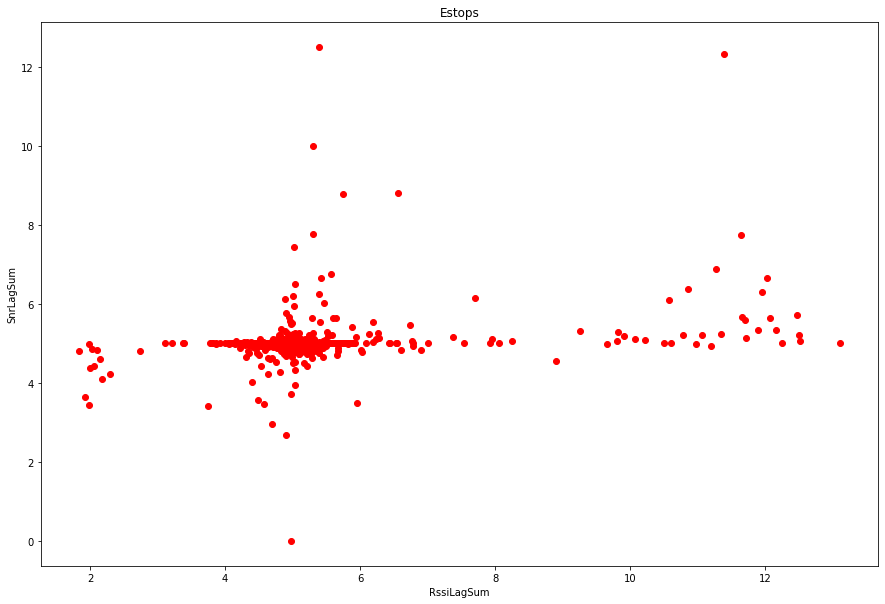

In [134]:
# Adding the relative measurements of prior segment passes and plotting

df_estops['RssiLagSum'] = df_estops[['A2_RSSI_mean-1', 'A2_RSSI_mean-2', 'A2_RSSI_mean-3', 'A2_RSSI_mean-4', 'A2_RSSI_mean-5']].sum(axis='columns')
df_estops['SnrLagSum'] = df_estops[['SNR1_mean-1', 'SNR1_mean-2', 'SNR1_mean-3', 'SNR1_mean-4', 'SNR1_mean-5']].sum(axis='columns')

plt.rcParams['figure.figsize'] = [15, 10]

x = df_estops['RssiLagSum']
y = df_estops['SnrLagSum']

plt.plot(x, y, 'ro', label='estops')
plt.xlabel('RssiLagSum')
plt.ylabel('SnrLagSum')
plt.title(f"Estops")

### Result
- A cluster of e-stops can be observed, where 'RssiLagSum' > 9.
- Are these the same e-stops that were found by the previous clustering model?

# 5: Forecasting of degradation-based estops
- To be done

# 6: Todo

Data preparation
- As the e-stops get triggered after specified intervals of time and distance with weak signals, the location of e-stops for a certain defect will depend on the direction in that the train passes the defect. So the estmated position of the e-stops should not be associated with the time they occured, but with the part of track that was passed in the specified time before.
- Create a feature of dropped RSSI values
- There are gaps between the segment passing times. Make sure, all e-stops get mapped to a segment pass. How many e-stops did not get mapped yet?
- The track areas at the start and at the end of the track seem to exprience a far greater ammount of estops than the rest of the track. I suspect a domain specific reason that still needs to be filtered out.

EDA: E-stops
- How are the e-stops distributed over time? Large-area events like heavy snowfall or flooding should become observable.

Clustering
- Use clustering to separate the degradation-based e-stops (with prior degradation) from the one caused by external reasons (without prior degradation).
- Use another clustering, to separate the e-stops caused by external reasons into the already known reasons (cow-herd fence, floodings, ...).
- Both above mentioned clusterings could be much approved, if labeled data could be delivered, maybe by the maintenance team.
- For the degradation-based e-stops, a forecast should be applied.

Forecasting
- At what levels of the signals do e-stops start to occur in the historical data?
- Predict the probability of an e-stop in next x days
- Predict the duration until e-stops will happen
- Model the connection of e-stops to features, then forecast features and determine future e-stops by trained model
  
Frontend
- Show all results in maps (plotly)